In [11]:
# Step 0: Machine Learning Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# Models for Comparison
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
import lightgbm as lgb

# --- Configuration ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_style('whitegrid')

In [12]:
# --- Step 1: Data Loading and Initial Cleaning ---
print("--- Step 1: Loading and Initial Data Cleaning ---")
try:
    df = pd.read_csv('networktraffic.csv', delimiter='|', on_bad_lines='skip')
    print(f"✅ Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
    print(f" Data preview: {df.head}")
except Exception as e:
    print(f"❌ Error loading CSV file: {e}")
    exit()

# Replace placeholder '-' with actual NaN for proper analysis
df.replace('-', np.nan, inplace=True)
print("✅ Replaced placeholder '-' with NaN.")

--- Step 1: Loading and Initial Data Cleaning ---
✅ Dataset loaded successfully with 10403 rows and 23 columns.
 Data preview: <bound method NDFrame.head of                  ts                 uid        id.orig_h  id.orig_p  \
0      1.533043e+09   C5JLGOoxIw2dBZt47  192.168.100.113        123   
1      1.533043e+09  Cf3cHf4jZr9nvD808i  192.168.100.113        123   
2      1.533043e+09  CJgmSt3bSY6XwE9fzc  192.168.100.113        123   
3      1.533043e+09  Cav32m4csR3OZYhShj  192.168.100.113        123   
4      1.533043e+09  ClwPfA40tU9UT4nksg  192.168.100.113        123   
...             ...                 ...              ...        ...   
10398  1.533129e+09  CnFPqm2V3khhpDHVph  192.168.100.113      47432   
10399  1.533129e+09  C76idj4jtLwpz9S3L7  192.168.100.113      38252   
10400  1.533129e+09   CkMeQi2atLqx0NfAR  192.168.100.113      38252   
10401  1.533129e+09  CypjCo4WicqE74GkUl  192.168.100.113        123   
10402  1.533129e+09  CC4Tss16O1KtMckgZj  192.168.100.113      


--- Step 2: Exploratory Data Analysis (EDA) ---

🔍 Analyzing missing values...
                count     percent
local_resp      10403  100.000000
local_orig      10403  100.000000
service         10403  100.000000
tunnel_parents  10403  100.000000
duration         6185   59.454004
orig_bytes       6185   59.454004
resp_bytes       6185   59.454004
detailed-label   2181   20.965106
proto               0    0.000000
id.resp_h           0    0.000000
id.resp_p           0    0.000000
id.orig_h           0    0.000000
uid                 0    0.000000
ts                  0    0.000000
id.orig_p           0    0.000000
missed_bytes        0    0.000000
conn_state          0    0.000000
history             0    0.000000
orig_pkts           0    0.000000
resp_pkts           0    0.000000
orig_ip_bytes       0    0.000000
resp_ip_bytes       0    0.000000
label               0    0.000000

Justification: Dropping columns with >50% missing values: ['service', 'duration', 'orig_bytes', 'resp_b

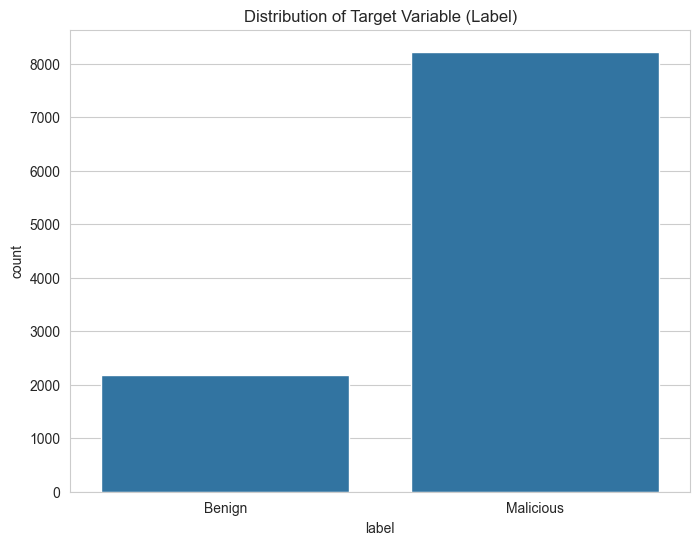

Justification: Target class is imbalanced. SMOTE will be used to address this.


In [13]:
# --- Step 2: Exploratory Data Analysis (EDA) & Justified Feature Elimination ---
print("\n--- Step 2: Exploratory Data Analysis (EDA) ---")

# 2a: Missing Value Analysis
print("\n🔍 Analyzing missing values...")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'count': missing_values, 'percent': missing_percent})
print(missing_df.sort_values(by='percent', ascending=False))

# Justification for dropping columns with high nulls
cols_to_drop_nulls = missing_df[missing_df['percent'] > 50].index.tolist()
if cols_to_drop_nulls:
    print(f"\nJustification: Dropping columns with >50% missing values: {cols_to_drop_nulls}")
    df.drop(columns=cols_to_drop_nulls, inplace=True)

# 2b: Identifier and High Cardinality Analysis
print("\n🔍 Analyzing high cardinality and identifier columns...")
# Justification for dropping identifiers and high-cardinality features
# These are unique to each connection and don't provide generalizable patterns.
# IP addresses could be engineered (e.g., subnet analysis), but for this model, we drop them.
identifier_cols = ['uid', 'id.orig_h', 'id.resp_h']
print(f"Justification: Dropping identifier columns: {identifier_cols}")
df.drop(columns=identifier_cols, inplace=True)

# 2c: Timestamp and Redundant Label Analysis
# Justification: 'ts' is a timestamp. We are building a model on connection features, not time-series patterns.
# 'detailed-label' is a source of data leakage as it's a more specific version of our target 'label'.
other_cols_to_drop = ['ts', 'detailed-label']
print(f"Justification: Dropping timestamp ('ts') and redundant label ('detailed-label').")
df.drop(columns=other_cols_to_drop, inplace=True)


# 2d: Statistical Description of Numerical Data
print("\n📊 Statistical Summary of Numerical Columns:")
# First, convert potential numeric columns to numeric types
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='ignore')
print(df.describe())

# 2e: Target Variable Distribution
print("\n📊 Visualizing Target Class Distribution...")
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Target Variable (Label)')
plt.show()
is_imbalanced = df['label'].value_counts(normalize=True).min() < 0.4
if is_imbalanced:
    print("Justification: Target class is imbalanced. SMOTE will be used to address this.")


--- Step 3: Final Preprocessing ---
✅ Imputed all remaining missing values.
✅ Encoded categorical features and target label.

📊 Visualizing Feature Correlation with Target...


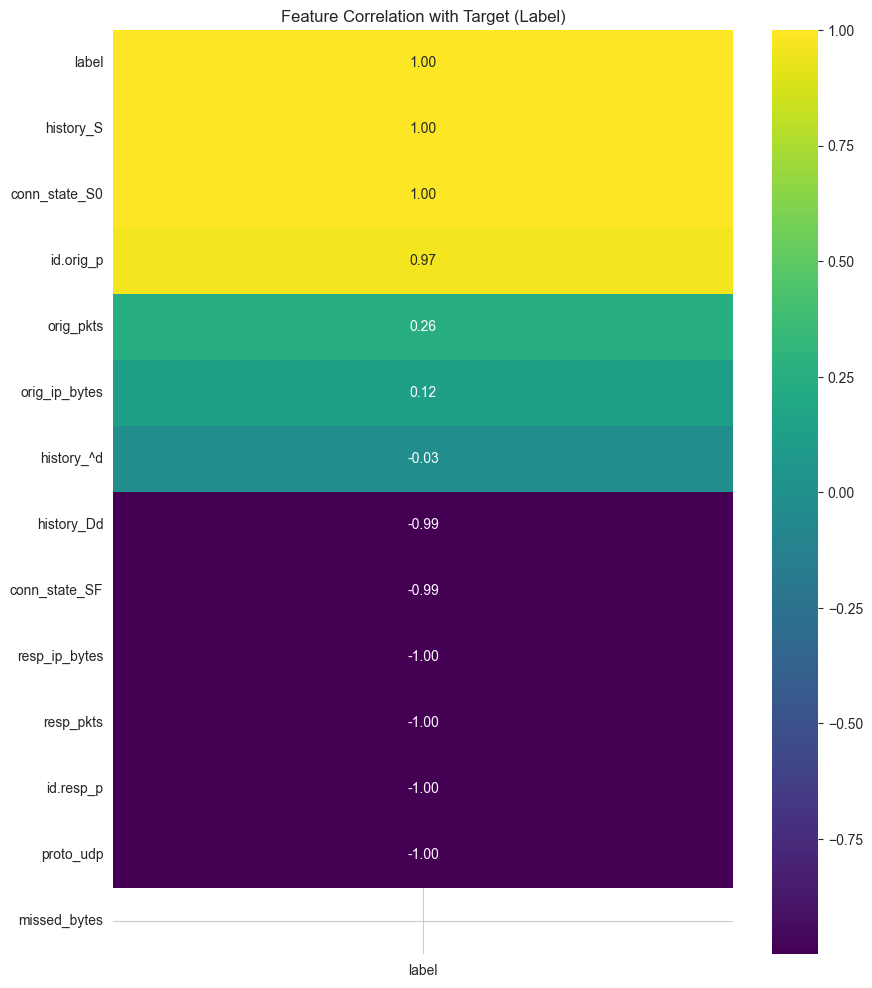

In [14]:
# --- Step 3: Final Preprocessing and Feature Engineering ---
print("\n--- Step 3: Final Preprocessing ---")
# Impute any remaining missing values
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include=['object', 'category']).columns:
    if col != 'label':
        df[col].fillna(df[col].mode()[0], inplace=True)

df.dropna(subset=['label'], inplace=True) # Drop rows where the label itself is missing
print("✅ Imputed all remaining missing values.")

# Encode categorical features and the target label
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('label')

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
label_encoder = LabelEncoder()
df_encoded['label'] = label_encoder.fit_transform(df_encoded['label'])
print("✅ Encoded categorical features and target label.")

# 2f: Correlation Heatmap (after encoding)
print("\n📊 Visualizing Feature Correlation with Target...")
plt.figure(figsize=(10, 12))
corr_matrix = df_encoded.corr()
target_corr = corr_matrix[['label']].sort_values(by='label', ascending=False)
sns.heatmap(target_corr, annot=True, cmap='viridis', fmt=".2f")
plt.title('Feature Correlation with Target (Label)')
plt.show()

In [17]:
# --- Step 3.5: Handling Data Leakage ---
leakage_cols_to_drop = ['history', 'conn_state', 'resp_ip_bytes', 'resp_pkts', 'id.resp_p', 'proto']
print(f"Justification: Dropping columns which showed perfect correlation on either sides (positive and negative.")
df.drop(columns=leakage_cols_to_drop, inplace=True)

Justification: Dropping columns which showed perfect correlation on either sides (positive and negative.


In [18]:
# --- Step 4: Model Training and Handling Class Imbalance ---
print("\n--- Step 4: Splitting Data and Applying SMOTE ---")
X = df_encoded.drop('label', axis=1)
y = df_encoded['label']

# Split data BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if is_imbalanced:
    print("Applying SMOTE to the training data...")
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("✅ SMOTE applied. Training set is now balanced.")


--- Step 4: Splitting Data and Applying SMOTE ---
Applying SMOTE to the training data...
✅ SMOTE applied. Training set is now balanced.



--- Step 5: Training and Evaluating Unsupervised Model ---

========== Training Isolation Forest ==========
Isolation Forest Accuracy: 0.7232

Classification Report for Isolation Forest:
              precision    recall  f1-score   support

      Benign       0.43      0.99      0.60       436
   Malicious       0.99      0.65      0.79      1645

    accuracy                           0.72      2081
   macro avg       0.71      0.82      0.69      2081
weighted avg       0.88      0.72      0.75      2081



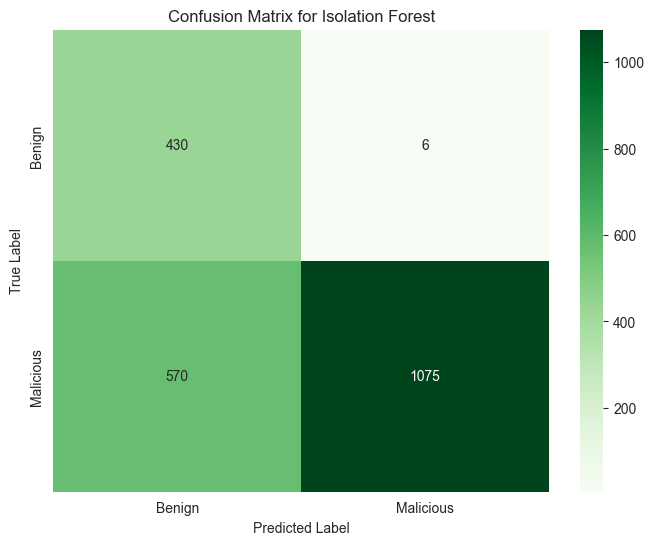

In [19]:
# --- Step 5: Unsupervised Anomaly Detection (Isolation Forest) ---
print("\n--- Step 5: Training and Evaluating Unsupervised Model ---")

# Calculate contamination based on the proportion of malicious traffic in the training set
contamination_rate = y_train.value_counts(normalize=True)[1]

print(f"\n{'='*10} Training Isolation Forest {'='*10}")
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)
iso_forest.fit(X_train)

# Predict on the test set. Model returns 1 for inliers and -1 for outliers.
y_pred_iso_raw = iso_forest.predict(X_test)

# Map predictions to our label encoding (0: Benign, 1: Malicious)
# Assumption: Outliers (-1) are Malicious (1), and Inliers (1) are Benign (0).
y_pred_iso = np.where(y_pred_iso_raw == -1, 1, 0)
iso_accuracy = accuracy_score(y_test, y_pred_iso)
print(f"Isolation Forest Accuracy: {iso_accuracy:.4f}")

# Store results for final comparison
results = {"Isolation Forest": iso_accuracy}

# Classification Report
print("\nClassification Report for Isolation Forest:")
print(classification_report(y_test, y_pred_iso, target_names=label_encoder.classes_))

# Confusion Matrix
cm_iso = confusion_matrix(y_test, y_pred_iso)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Isolation Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- Step 6: Training and Evaluating Multiple Models ---

========== Training Logistic Regression ==========

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       436
   Malicious       1.00      1.00      1.00      1645

    accuracy                           1.00      2081
   macro avg       1.00      1.00      1.00      2081
weighted avg       1.00      1.00      1.00      2081



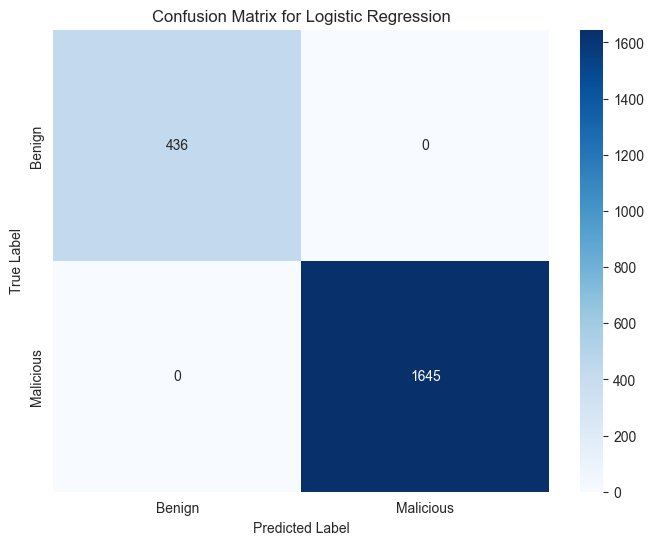


========== Training Decision Tree ==========

Classification Report for Decision Tree:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       436
   Malicious       1.00      1.00      1.00      1645

    accuracy                           1.00      2081
   macro avg       1.00      1.00      1.00      2081
weighted avg       1.00      1.00      1.00      2081



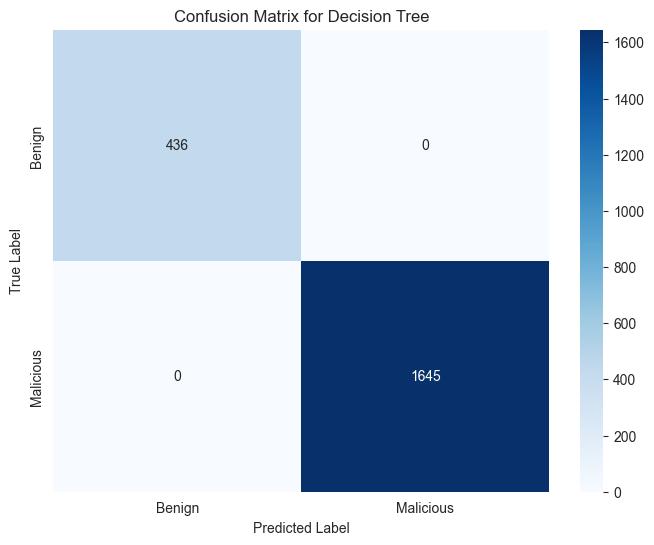


========== Training Random Forest ==========

Classification Report for Random Forest:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       436
   Malicious       1.00      1.00      1.00      1645

    accuracy                           1.00      2081
   macro avg       1.00      1.00      1.00      2081
weighted avg       1.00      1.00      1.00      2081



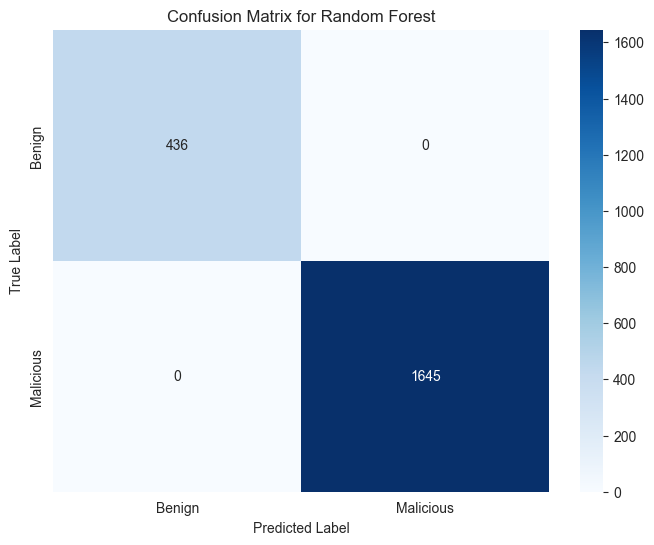


========== Training LightGBM ==========
[LightGBM] [Info] Number of positive: 6577, number of negative: 6577
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 13154, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

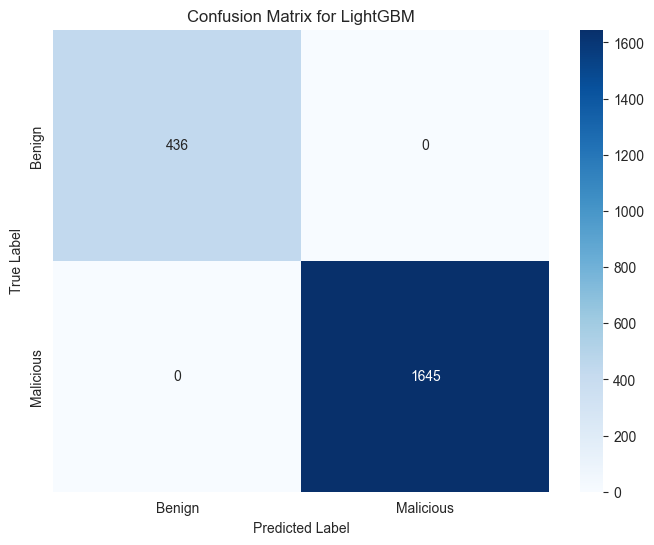

In [20]:
# --- Step 6: Train and Compare Multiple Models ---
print("\n--- Step 6: Training and Evaluating Multiple Models ---")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n{'='*10} Training {name} {'='*10}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    # Individual Classification Report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Individual Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


--- Step 6: Final Model Comparison ---

📊 Final Accuracy Comparison:
                 Model  Accuracy
0  Logistic Regression       1.0
1        Decision Tree       1.0
2        Random Forest       1.0
3             LightGBM       1.0


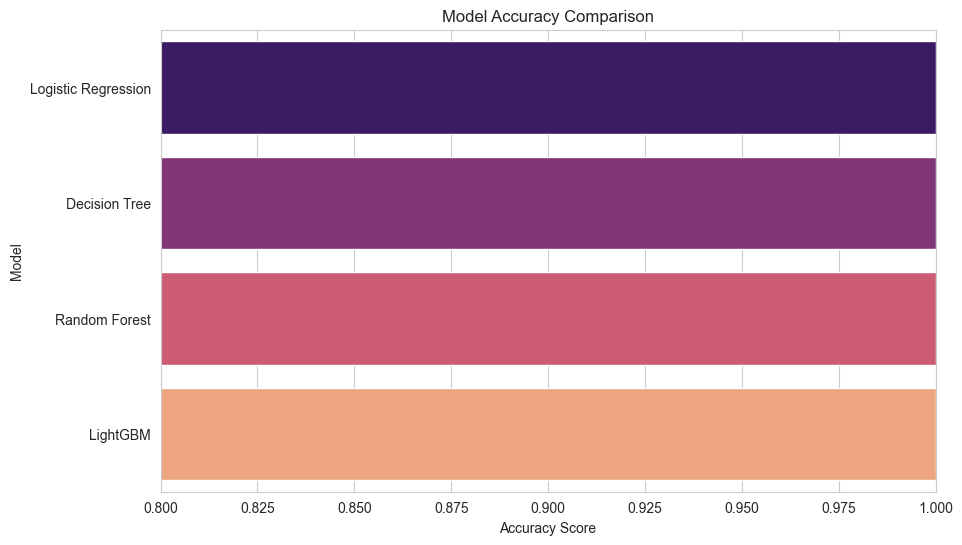


🏆 Conclusion: Based on accuracy, the best performing model is **Logistic Regression**.


In [ ]:
# --- Step 7: Final Comparison and Conclusion ---
print("\n--- Step 7: Final Model Comparison ---")
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)

print("\n📊 Final Accuracy Comparison:")
print(results_df)

# Visualize the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='magma')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy Score')
plt.xlim(0.8, 1.0)
plt.show()

best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Conclusion: Based on accuracy, the best performing model is **{best_model_name}**.")